# Plot Global Irradiance on tilted surface

### Prerequesits:

To create the plot you need irradiance data. In this notebook, [ERA5](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5) weather data is used that is provided through the [Climate Data Store (CDS)](https://cds.climate.copernicus.eu).

(1) In order to download ERA5 weather data you need to **register** at the [CDS](https://cds.climate.copernicus.eu/user/register). 

(2) The data can be downloaded using the automated download provided in this notebook (using the [feedinlib](https://github.com/oemof/feedinlib) that utilizes the CDS API). To use the automated download you need to **install the cdsapi package**. See [here](https://cds.climate.copernicus.eu/api-how-to) for installation details. 

### Content:

* [User input](#user_input)
* [Download weather data](#weather_data)
* [Plot global irradiance](#plot_global_irradiance)


## User input <a class="anchor" id="user_input"></a>

Please specify here for which

In [1]:
# year for which to create plot and/or download weather data
year = 2019

### Input for weather data download

In case you have already downloaded the needed weather data please provide the name of the netcdf file in *weather_data_filename*. Otherwise set *weather_data_filename* to *None* and specify latitude and longitude of the location(s) for which you want to download the data. In case you want to download data for a region provide latitude and longitude in the following form:

```python
latitude_download = [52.3, 52.7]  # [latitude south, latitude north]
longitude_download = [13.1, 13.6]  # [longitude west, longitude east]
```

In [2]:
# can be ignored if weather data is already downloaded
latitude_download = 52.47
longitude_download = 13.30

# set to None if you want to download weather data, otherwise provide filename of netcdf file
weather_data_filename = 'ERA5_weather_data_lat_52.47_lon_13.3_date_2019-01-01_to_2019-12-31.nc'

### Input for plotting

Please specify the latitude and longitude of the location you want to create the plot for. Other than the download, which can be conducted for a region, the plot can only be created for a single location, wherefore latitude and longitude must be single values.

In [3]:
# latitude and longitude used in plot must be single values
latitude_plot = latitude_download
longitude_plot = longitude_download

The following variables can be left as they are and only need to be changed if fine tuning of the plot is needed.

*azimuths_number_of_points* and *tilts_number_of_points* set the number of combinations of azimuths and tilts the sum of the global irradiance is calculated for. The higher the number the longer the calculation time but the higher the resolution of the plot.

In [42]:
azimuths_number_of_points = 120
tilts_number_of_points = 30

Through the following parameters you may change the fontsizes used in the plot, etc.

In [46]:
axes_label_fontsize = 22
contour_label_fontsize = 12
unit_label_fontsize = 12
figsize = (14, 8)
colormap_year = 'RdYlGn_r'
colormap_summer = 'YlGn'
colormap_winter = 'winter'

## Download ERA5 weather data <a class="anchor" id="weather_data"></a>

The following code is only executed if required weather has not been previously downloaded, i.e. *weather_data_filename* is not provided but set to *None*.

In [6]:
from feedinlib import era5

# download weather data for specified location
if weather_data_filename is None:
    weather_data_filename = "ERA5_weather_data_lat_{}_lon_{}_date_{}_to_{}.nc".format(
        latitude_download, longitude_download, start_date, end_date)
    start_date, end_date = '{}-01-01'.format(year), '{}-12-31'.format(year)
    ds = era5.get_era5_data_from_datespan_and_position(
        variable="pvlib",
        start_date=start_date, end_date=end_date, 
        latitude=latitude_download, longitude=longitude_download,
        target_file=weather_data_filename)

## Plot global irradiance on tilted surface <a class="anchor" id="plot_global_irradiance"></a>

In [7]:
import numpy as np
from pvlib.modelchain import ModelChain
from pvlib.pvsystem import PVSystem
from pvlib.location import Location
from feedinlib.models import get_power_plant_data

In [9]:
# get weather data for single location
start_date, end_date = '{}-01-01'.format(year), '{}-12-31'.format(year)
weather_df = era5.weather_df_from_era5(
    era5_netcdf_filename=weather_data_filename,
    lib='pvlib',
    area=[longitude_plot, latitude_plot],
    start=start_date, 
    end=end_date)

In [43]:
# calculate sum of global horizontal irradiance on tilted surface in kWh/(m²a) for 
# azimuths from -180° to 180° and tilt angles from 0° to 90°

summer_start = '{}-05-01'.format(year)
summer_end = '{}-10-01'.format(year)
winter_start = '{}-11-01'.format(year)
winter_end = '{}-04-01'.format(year)

azimuths = np.linspace(0.0, 360.0, azimuths_number_of_points)
tilts = np.linspace(0.0, 90.0, tilts_number_of_points)
sum_global_irr_tilted_surface_year = np.zeros(
    (tilts_number_of_points, azimuths_number_of_points))
sum_global_irr_tilted_surface_summer = np.zeros(
    (tilts_number_of_points, azimuths_number_of_points))
sum_global_irr_tilted_surface_winter = np.zeros(
    (tilts_number_of_points, azimuths_number_of_points))

location = Location(
    latitude=latitude_plot,
    longitude=longitude_plot,
    tz=weather_df.index.tz)

# dummy PV system parameters for pvlib ModelChain
module_name = 'Advent_Solar_Ventura_210___2008_'  # module name as in database
inverter_name = 'ABB__MICRO_0_25_I_OUTD_US_208__208V_'  # inverter name as in database
pv_system_data = {
    'module_parameters': get_power_plant_data("SandiaMod")[module_name],
    'inverter_parameters': get_power_plant_data("CECInverter")[inverter_name],  
    'albedo': 0.2}

for i in range(len(tilts)):
    pv_system_data['surface_tilt'] = tilts[i]
    for j in range(len(azimuths)):
        pv_system_data['surface_azimuth'] = azimuths[j]
        pv_system = PVSystem(**pv_system_data)
        mc = ModelChain(pv_system, location)
        mc.complete_irradiance(weather=weather_df)
        mc.prepare_inputs(weather_df)
        poa_global = mc.total_irrad.poa_global
        sum_global_irr_tilted_surface_summer[i, j] = poa_global.loc[
            (poa_global.index >= summer_start) & (poa_global.index < summer_end)].sum() / 1e3
        sum_global_irr_tilted_surface_winter[i, j] = poa_global.loc[
            (poa_global.index >= winter_start) | (poa_global.index < winter_end)].sum() / 1e3
        sum_global_irr_tilted_surface_year[i, j] = poa_global.sum() / 1e3

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib

def create_plot(data, colormap, plot_filename, unit_label_text):
    
    # set label font size
    font = {'size': axes_label_fontsize}
    matplotlib.rc('font', **font)

    plt.figure(figsize=figsize)

    azimuths = np.linspace(-180.0, 180.0, azimuths_number_of_points)
    tilts = np.linspace(0.0, 90.0, tilts_number_of_points)
    X, Y = np.meshgrid(azimuths, tilts)

    # plot contour lines at specified levels with labels
    min_contour_line = int(np.floor(data.min() / 100.0)) * 100
    max_contour_line = int(np.floor(data.max() / 100.0)) * 100
    levels = list(np.arange(min_contour_line, max_contour_line+1, 50.)) + \
        [np.ceil(data.max())]
    contour = plt.contour(X, Y, data, levels, colors='k')
    plt.clabel(contour, colors = 'k', fmt = '%4.0f', fontsize=contour_label_fontsize)

    # plot filled contour with colors specified by colormap
    cmap = cm.get_cmap(colormap)
    contour_filled = plt.contourf(X, Y, data, levels, cmap=cmap)

    # add max value label
    ind_max_value = np.unravel_index(
        np.argmax(
            data, axis=None),
        data.shape)
    plt.scatter(azimuths[ind_max_value[1]], tilts[ind_max_value[0]],
                marker='o', facecolors='none', edgecolors='k', s=80)
    plt.text(azimuths[ind_max_value[1]]+3, tilts[ind_max_value[0]],
             str(int(np.ceil(data.max()))),
             fontsize=unit_label_fontsize, 
             horizontalalignment='left', 
             verticalalignment='top')

    # add axes and tick labels
    plt.xlabel('Azimuthwinkel in °', horizontalalignment='right', x=1.0)
    plt.ylabel('Neigungswinkel in °')
    axes = plt.gca()
    axes.set_xticks(np.arange(-180, 190, 30))
    axes.set_yticks(np.arange(0, 100, 10))

    # add cardinal direction at top of plot
    ax2 = axes.twiny()
    ax2.set_xlim(axes.get_xlim())
    ax2.set_xticks([-180, -90, 0, 90, 180])
    ax2.set_xticklabels(['Nord', 'Ost', 'Süd', 'West', 'Nord'])

    # unit label
    plt.text(0.99, 0.01, unit_label_text,
             fontsize=unit_label_fontsize, 
             horizontalalignment='right', 
             verticalalignment='bottom', 
             transform = axes.transAxes)

    plt.savefig(plot_filename)

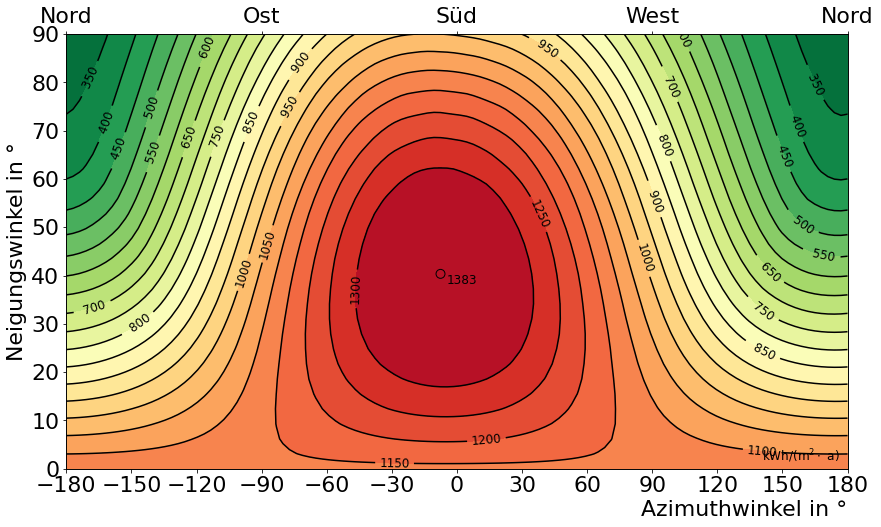

In [47]:
# plot year
plot_filename = 'Jahressumme_Globalstrahlung_lat_{}_lon_{}_Jahr_{}.pdf'.format(
    latitude_plot, longitude_plot, year)
create_plot(sum_global_irr_tilted_surface_year,
            colormap_year,
            plot_filename,
            'kWh/(m$^2 \cdot$ a)')

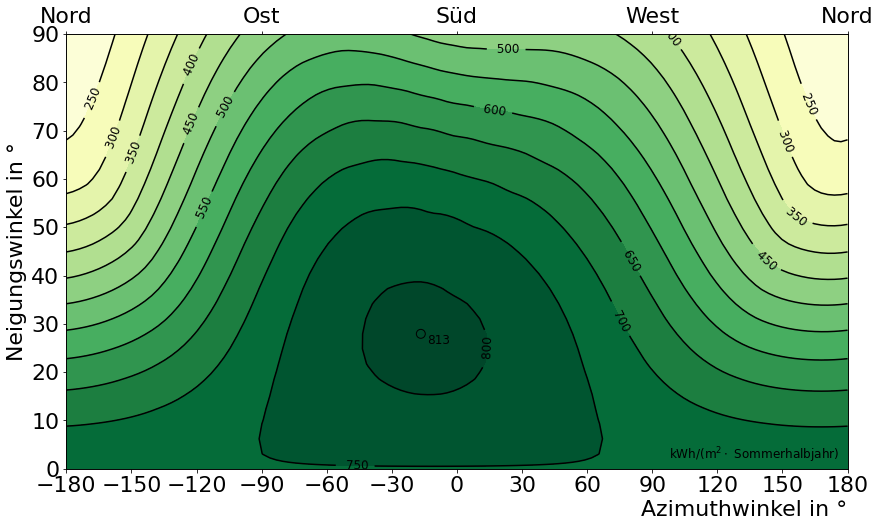

In [48]:
# plot summer
plot_filename = 'Jahressumme_Globalstrahlung_lat_{}_lon_{}_Sommerhalbjahr_{}.pdf'.format(
    latitude_plot, longitude_plot, year)
create_plot(sum_global_irr_tilted_surface_summer,
            colormap_summer,
            plot_filename,
            'kWh/(m$^2 \cdot$ Sommerhalbjahr)')

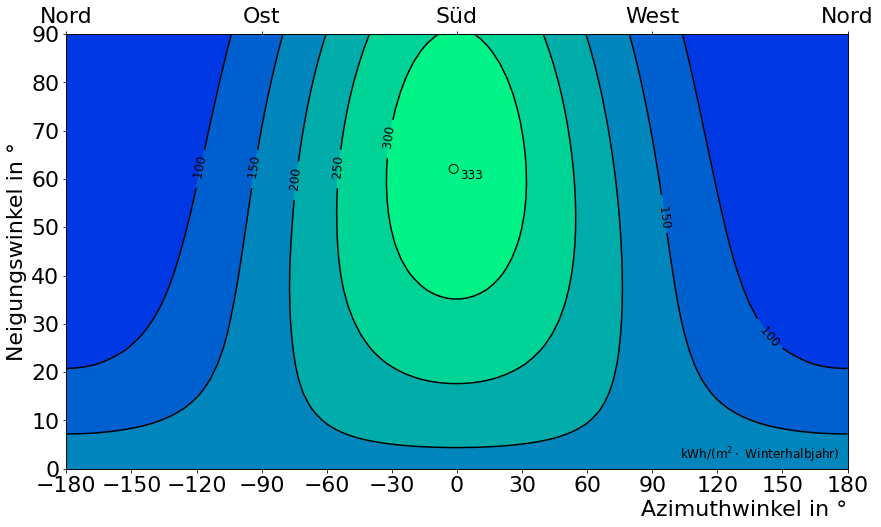

In [49]:
# plot winter
plot_filename = 'Jahressumme_Globalstrahlung_lat_{}_lon_{}_Winterhalbjahr_{}.pdf'.format(
    latitude_plot, longitude_plot, year)
create_plot(sum_global_irr_tilted_surface_winter,
            colormap_winter,
            plot_filename,
            'kWh/(m$^2 \cdot$ Winterhalbjahr)')